# 1. Introduction

Test starts:
We get data for the period: 2020/07/01 - 2020/08/05




In [ ]:
# load packages
#import folium
#from folium import FeatureGroup, LayerControl
#from folium.plugins import TimestampedGeoJson
#from folium import plugins
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io import gbq
from google.cloud import bigquery
#import geopandas
from shapely import wkt
%matplotlib inline
from google.colab import drive # to allow colab save file in my drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
cwd=os.getcwd()
cwd
%unload_ext google.colab.data_table

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Authenticated
The google.colab.data_table extension is not loaded.


In [ ]:
# define project id
project_id = "fulfillment-dwh-production"
#client = bigquery.Client(project = project_id)
%cd "/content/drive/Shared drives/Global Pricing/2 - Entities/APAC/Hong Kong/3 - DPS Tests/Test_20200717"
%pwd
%ls

/content/drive/Shared drives/Global Pricing/2 - Entities/APAC/Hong Kong/3 - DPS Tests/Test_Proposal_20200519
 DPS_HK.ipynb          HK_Test_Setup_20200715.gsheet
 DPS_HK_Test.gslides  'HongKong DPS Test Proposal_20200525.gslides'
 hk_test_pandora.csv   proposal_20200708.xlsx


# 2. Data collection

## 2.1 Shrinking & Closure - System setting

In [ ]:
query1 = """
SELECT
  zo.id as zone_id,
  zo.name as zone_name,
  e.*
FROM
  `fulfillment-dwh-production.cl.countries` co, co.cities ci , ci.zones zo, zo.events e
WHERE country_code = 'hk' and zo.id in (27,45,36,50,31,43,70,52)
    """

shrink = client.query(query1).to_dataframe()
shrink

,zone_id,zone_name,id,action,activation_threshold,deactivation_threshold,starts_at,ends_at,title,value,message,updated_at,is_shape_in_sync,shape,delivery_provider,cuisines,is_halal,tags,vertical_type,characteristics
0,27,Ma on shan rider,28,shrink,12,8,None,None,AUTO_MaOnShan_Shrink_1st,9.0,{},2020-04-27 15:28:57.143801+00:00,True,"POLYGON((114.2393589 22.4388769, 114.2351745 2...",[platform_delivery],[],None,[],None,[]
1,27,Ma on shan rider,29,shrink,19,15,None,None,AUTO_MaOnShan_Shrink_2nd,4.0,"{""en_HK"": ""Due to a high volume of orders, our...",2020-08-05 23:09:26.571107+00:00,True,"POLYGON((114.2393589 22.4388769, 114.2351745 2...",[platform_delivery],[],None,[],None,[]
2,27,Ma on shan rider,147,close,23,19,None,None,AUTO_MaOnShan_Close,NaN,"{""en_HK"": ""Due to a high volume of orders, our...",2020-08-05 23:31:29.117571+00:00,True,"POLYGON((114.2393589 22.4388769, 114.2351745 2...",[platform_delivery],[],None,[],None,[]
3,27,Ma on shan rider,1736,shrink,15,11,None,None,AUTO_MaOnShan_Shrink_1st,9.0,{},2020-08-06 01:39:26.407379+00:00,True,"POLYGON((114.2393589 22.4388769, 114.2351745 2...",[platform_delivery],[],None,[],None,[]
4,45,Ma on shan walker,346,close,24,19,None,None,AUTO_MaOnShanWalker_Close,NaN,"{""en_HK"": ""Due to a high volume of orders, our...",2020-08-03 14:58:28.455654+00:00,True,"POLYGON((114.2402817 22.4342457, 114.2336834 2...",[platform_delivery],[],None,[],None,[]
5,36,Sheung shui rider,5,close,24,20,None,None,AUTO_SheungShui_Close,NaN,"{""en_HK"": ""Due to a high volume of orders, our...",2020-08-03 23:31:30.704453+00:00,True,"POLYGON((114.118239 22.506481, 114.118068 22.5...",[platform_delivery],[],None,[],None,[]
6,36,Sheung shui rider,13,shrink,16,12,None,None,AUTO_SheungShui_shrink_1st,9.0,{},2020-08-05 23:43:29.034845+00:00,True,"POLYGON((114.118239 22.506481, 114.118068 22.5...",[platform_delivery],[],None,[],None,[]
7,36,Sheung shui rider,101,shrink,20,16,None,None,AUTO_SheungShui_shrink_2nd,4.0,"{""en_HK"": ""Due to a high volume of orders, our...",2020-08-05 13:36:55.364161+00:00,True,"POLYGON((114.118239 22.506481, 114.118068 22.5...",[platform_delivery],[],None,[],None,[]
8,50,Sheung shui walker,509,close,28,24,None,None,AUTO_SheungShuiWalker_Close,NaN,"{""en_HK"": ""Due to a high volume of orders, our...",2020-08-03 14:58:28.455654+00:00,True,"POLYGON((114.1238361 22.5042689, 114.1240507 2...",[platform_delivery],[],None,[],None,[]
9,31,Tai po rider,44,shrink,17,14,None,None,AUTO_TaiPo_Shrink_1st,9.0,{},2020-08-04 01:05:30.515841+00:00,True,"POLYGON((114.1437779 22.4632752, 114.1476408 2...",[platform_delivery],[],None,[],None,[]


## 2.2 Order level delivery fee




In [ ]:
# Get relevant data from big query

query2 = """

select
o.platform_order_code,
z.name zone_name,
z.id zone_id,
vendor.id vendor_id,
vendor.vendor_code vendor_code,
vendor.name vendor_name,
cast(o.order_placed_at as date) order_date,
p.drive_time_value,
st_distance(vendor.location,customer.location) as delivery_distance
from fulfillment-dwh-production.cl.orders o
left join unnest(deliveries) d
left join unnest(porygon) p
left join cl.countries on o.country_code = countries.country_code
left join unnest(cities) c on c.id = o.city_id
left join unnest(zones) z on z.id = o.zone_id
where
o.country_code = 'hk'
and o.order_status = 'completed'
and d.delivery_status = 'completed'
and o.created_date between '2020-07-01' and '2020-08-04'
and p.vehicle_profile = 'default'
and z.id in (27,45,36,50,31,43,70,52)

    """

bigquery = client.query(query2).to_dataframe()
bigquery.head()

,platform_order_code,zone_name,zone_id,vendor_id,vendor_code,vendor_name,order_date,drive_time_value,delivery_distance
0,w6mq-lrry,Tin shui wai walker,52,20306,w6mq,Bao Dim Sin Seng (Tin Yiu),2020-07-23,5,33.023032
1,w8gc-elv7,Tin shui wai rider,70,9953,w8gc,McDonald's (Fortune Kingswood I),2020-07-23,8,764.295057
2,v8kd-ecrf,Sheung shui rider,36,14961,v8kd,Maxim's MX (Fanling Station),2020-07-23,9,1156.989178
3,w4nv-4yhl,Sheung shui walker,50,21322,w4nv,Café 100% (Green Code),2020-07-23,6,366.299481
4,v7oz-z2dj,Tin shui wai walker,52,13050,v7oz,Siu War Mai Sin (Tin Shui Wai),2020-07-23,4,238.046393


In [ ]:
# load pandora data
pandora = pd.read_csv("hk_test_pandora.csv")

In [ ]:
pandora.head()

,zone_name,created_date,order_code_google,porygon_vehicle_profile,drive_time_value,gmv_local,gfv_local,service_fee,delivery_fee,df_voucher,other_voucher,df_discount,other_discount
0,Tai po walker,2020-08-04,q0rx-5rtu,default,6,600.0,580.0,0,20,0,0.0,0,174.0
1,Tai po rider,2020-08-02,q0rx-98oh,default,7,422.0,402.0,0,20,0,0.0,0,120.6
2,Tai po rider,2020-07-30,q0rx-dnsw,default,10,452.0,432.0,0,20,0,0.0,0,129.6
3,Tai po walker,2020-07-29,q0rx-puyi,default,6,437.0,432.0,0,5,0,0.0,0,129.6
4,Tai po walker,2020-08-01,q0rx-vkbn,default,9,560.0,545.0,0,15,0,0.0,0,163.5


In [ ]:
df = pd.merge(bigquery,
              pandora,
              left_on = "platform_order_code",
              right_on = "order_code_google",
              how = "left")

In [ ]:
df = df.drop(["zone_name_y", "vendor_id","created_date", "order_code_google", "porygon_vehicle_profile", "drive_time_value_y"],axis = 1)
df.loc[(df.zone_name_x == "Tin shui wai walker"), "zone_name_x"] = "Tin shui wai"
df.loc[(df.zone_name_x == "Tin shui wai rider"), "zone_name_x"] = "Tin shui wai"
df.loc[(df.zone_name_x == "Sheung shui rider"), "zone_name_x"] = "Sheung shui"
df.loc[(df.zone_name_x == "Sheung shui walker"), "zone_name_x"] = "Sheung shui"
df.loc[(df.zone_name_x == "Tai po rider"), "zone_name_x"] = "Tai po"
df.loc[(df.zone_name_x == "Tai po walker"), "zone_name_x"] = "Tai po"
df.loc[(df.zone_name_x == "Ma on shan rider"), "zone_name_x"] = "Ma on shan"
df.loc[(df.zone_name_x == "Ma on shan walker"), "zone_name_x"] = "Ma on shan"
df["travel_time"] = df["delivery_distance"]*7.454451103/1000
df.head()

,platform_order_code,zone_name_x,zone_id,vendor_code,vendor_name,order_date,drive_time_value_x,delivery_distance,gmv_local,gfv_local,service_fee,delivery_fee,df_voucher,other_voucher,df_discount,other_discount,travel_time
0,w6mq-lrry,Tin shui wai,52,w6mq,Bao Dim Sin Seng (Tin Yiu),2020-07-23,5,33.023032,86.0,81.0,0.0,5.0,0.0,15.0,0.0,0.0,0.246169
1,w8gc-elv7,Tin shui wai,70,w8gc,McDonald's (Fortune Kingswood I),2020-07-23,8,764.295057,116.0,101.0,0.0,15.0,0.0,15.0,0.0,10.1,5.697400
2,v8kd-ecrf,Sheung shui,36,v8kd,Maxim's MX (Fanling Station),2020-07-23,9,1156.989178,160.0,140.0,0.0,20.0,0.0,0.0,0.0,42.0,8.624719
3,w4nv-4yhl,Sheung shui,50,w4nv,Café 100% (Green Code),2020-07-23,6,366.299481,103.0,88.0,0.0,15.0,0.0,0.0,0.0,0.0,2.730562
4,v7oz-z2dj,Tin shui wai,52,v7oz,Siu War Mai Sin (Tin Shui Wai),2020-07-23,4,238.046393,46.0,41.0,0.0,5.0,0.0,0.0,0.0,0.0,1.774505


In [ ]:
#subset = df[(df['order_date'] >= '2020-04-10 00:00:00') & (df['order_date'] <= '2020-04-30 23:59:59')]
df.to_csv('df_test.csv')
#!cp hk.csv "/content/drive/Shared drives/Global Pricing/2 - Entities/Foodpanda/HK Foodpanda"

## 2.3 Delay, shrink & closure

In [ ]:
query3 = """



"""

event = client.query(query3).to_dataframe()
event.head()

,platform_order_code,zone_name,delivery_distance,drive_time_value,created_date,estimated_driving_time
0,w6xk-16ez,Mongkok walker,0,1,2020-04-18,240.0
1,w4ws-a9dl,Happy valley cwb walker,409,8,2020-04-18,300.0
2,w8kr-enq4,Wan chai cwb walker,446,5,2020-04-18,300.0
3,w8kr-xl2k,Wan chai cwb walker,359,6,2020-04-18,300.0
4,v4vi-4hmg,Wan chai cwb walker,588,5,2020-04-18,300.0


In [ ]:
travel_time["delta"].mean()

0.3765334831942782

In [ ]:
travel_time["delivery_distance"].max()

9564

In [ ]:
pivot1 = travel_time.groupby("drive_time_value")["platform_order_code"].count()
pivot2 = travel_time.groupby("travel_time_A")["platform_order_code"].count()

In [ ]:
travel_time.head()

,platform_order_code,zone_name,delivery_distance,drive_time_value,created_date,estimated_driving_time,travel_time_A,travel_time_B,delta
0,w6xk-16ez,Mongkok walker,0,1,2020-04-18,240.0,4.0,4.180000,3.180000
1,w4ws-a9dl,Happy valley cwb walker,409,8,2020-04-18,300.0,5.0,5.838904,-0.270137
2,w8kr-enq4,Wan chai cwb walker,446,5,2020-04-18,300.0,5.0,5.988976,0.197795
3,w8kr-xl2k,Wan chai cwb walker,359,6,2020-04-18,300.0,5.0,5.636104,-0.060649
4,v4vi-4hmg,Wan chai cwb walker,588,5,2020-04-18,300.0,6.0,6.564928,0.312986


In [ ]:
type(pivot1)

pandas.core.series.Series

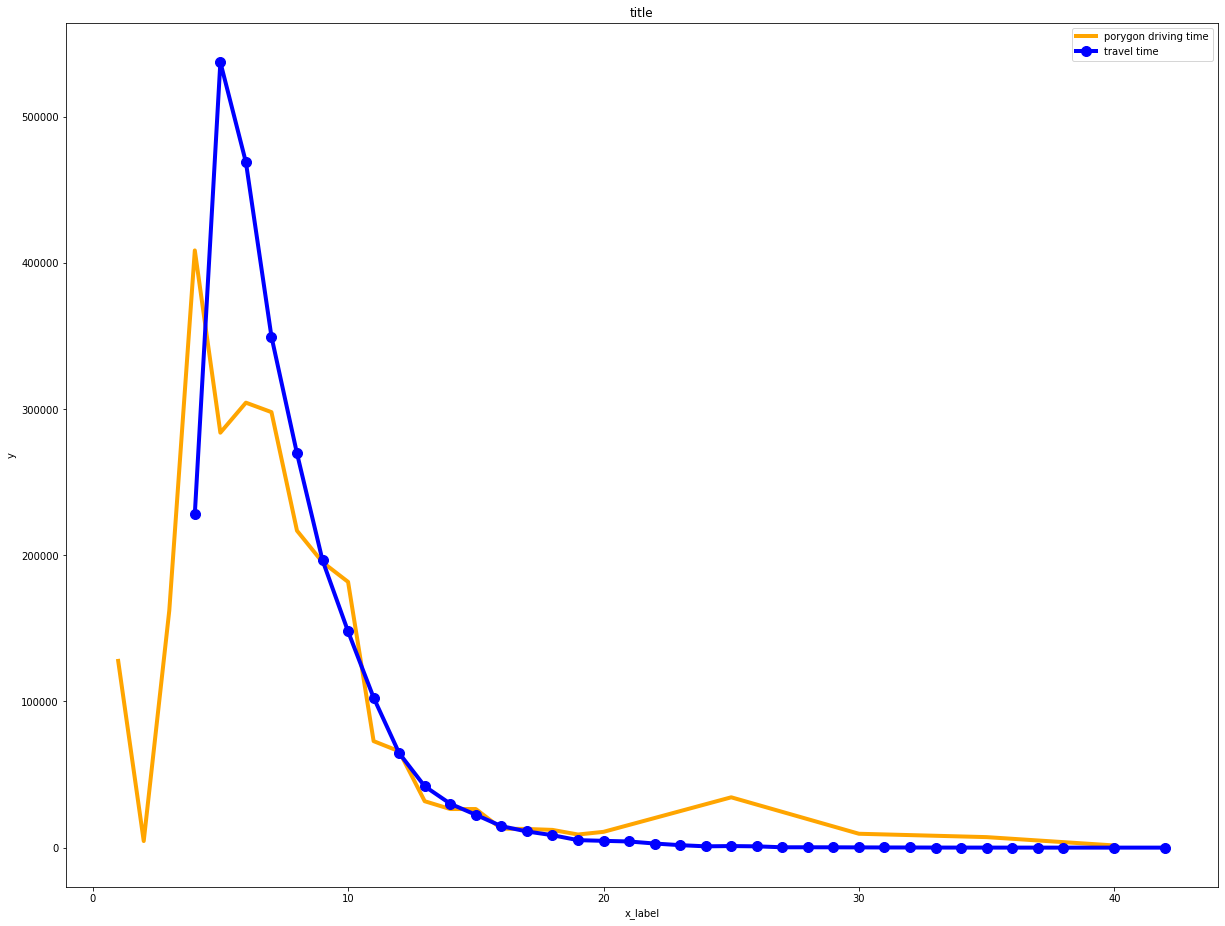

In [ ]:
fig = plt.figure(figsize=(20,15))
axes = fig.add_axes([0.1,0.1,0.8,0.8])

axes.plot(pivot1, label = "porygon driving time", color = "orange", linewidth =4) # color RGB Hex Code, alpha = transparency level
axes.plot(pivot2, label = "travel time", color = "blue", linewidth = 4, marker = "o", markersize=10) # linestype
axes.set_xlabel("x_label")
axes.set_ylabel("y")
axes.set_title("title")

axes.legend(loc=0)

#zooming
#axes.set_xlim([0,1])
#axes.set_ylim([0,1])


In [ ]:
fig,axes = plt.subplots(nrow = 1, ncols=2, figsize=(8,2))
axes[0].plot(x,y)
axes[1].plot(y,x)
plt.tight_layout()

fig.savefig("my_picture.png")